# Malaria Project - Implementation
## Detecting Malaria cells using CNN and TF 2.0


### By:
- Lukas Wagner s0556753
- Laila Westphal s0556469


## Table of Contents:
* [Introduction](#Introduction)
* [Brief discussion about existing kernels](#Brief-discussion-about-existing-kernels)
  * [Kernel 1](#Kernel-1:-Detecting-Malaria-cells-using-Convolutional-Neural-Network)
* [Getting Started](#Getting-Started) 
  * [Imports](#Imports)
  * [Load Data](#LoadData)
* [Preprocess Data](#Preprocess-Data)
  * [Feature Engineering](#Feature-Engineering)
  * [Data Augmentation](#Data-Augmentation)
  * [Visualizing Augmented Data](#Visualizing-Augmented-Data)
  * [Generate Data and Labels](#Generate-all-Data-and-Labels)
  * [Save/Load Data](#Save/Load-Data)
  * [Data-Visualization](#Data-Visualization)
  * [Split Data](#Split-Data)
* [Setup CNN](#Setup-CNN)
* Train data
* Evaluate?
* Predictions using test data
* Visualize Accuracy
* Results, Confusion Matrix
* Visualize Results
* Licenses
* Acknowledgements


# Introduction

# Brief discussion about existing kernels

In this section two kernels from the kaggle website dealing with the malaria dataset will be analized regarding data augmentation, data-split, cnn-architecture, used activation functions and obtained results (accuracy ...).
They are being used as a guideline for our own implementation.

## Kernel 1: Detecting Malaria cells using Convolutional Neural Network
### By: Kushal Mahindrakar
Source:https://www.kaggle.com/kushal1996/detecting-malaria-cnn

#### Data Augmentation:
- Done using the Python Image Libary (PIL) that provides support for opening, editing and saving many different data formats
- The quantity of the "Parasitized" data is being quadrupled.
- The quantity of the "Uninfected" data is being tripled.

#### Data-Split
The data in this kernel is being split into training, evaluation and test data:
   - training-data: 80%
   - evaluation-data: 10%
   - test-data: 10%

#### Used CNN-Architecture and activation functions:

| Layer-Type   | Units | Nb_Filters | KernelSize PoolSize | Padding | Activation | Stride |
|--------------|-------|------------|---------------------|---------|------------|--------|
| Input        | _     | _          | _                   | _       | _          | _      |
|  Conv        | _     | 50         | 7x7                 | same    | ReLU       | _      |
| Conv         | _     | 90         | 3x3                 | valid   | ReLU       | _      |
| Conv         | _     | 10         | 5x5                 | same    | ReLU       | _      |
| Pool         | _     | _          | 2x2                 | _       | _          | 2      |
| Conv         | _     | 5          | 3x3                 | same    | ReLU       | _      |
| Pool         | _     | _          | 2x2                 | same    | _          | 2      |
| Pool_flatten | _     | _          | _                   | _       | _          | _      |
| FC           | 2000  | _          | _                   | _       | ReLU       | _      |
| FC           | 1000  | _          | _                   | _       | ReLU       | _      |
| FC           | 500   | _          | _                   | _       | ReLU       | _      |
| Logits       | 2     | _          | _                   | _       | _          | _      |

#### Obtained Results:

| _           | precision |   recall | f1-score |  support |
|-------------|-----------|----------|----------|----------|
|           0 |      0.90 |     0.93 |     0.91 |     4223 |
|           1 |      0.95 |     0.92 |     0.93 |     5423 |
|_            | _         | _        | _        | _        |
|   micro avg |      0.92 |     0.92 |     0.92 |     9646 |
|   macro avg |      0.92 |     0.92 |     0.92 |     9646 |
|weighted avg |      0.92 |     0.92 |     0.92 |     9646 |
| _           | _         | _        | _        | _        |
|0.9238026124818578



# Getting Started

## Imports

In [1]:
# Uncomment to install TF 2.0 if you don't have it
#!pip install tensorflow==2.0.0-beta1

In [10]:
# linear algebra
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# computer vision library, image processing
import cv2

# statistical data visualization
import seaborn as sns

# used for data augmentation
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

# to use operating system dependent functionality
import os

import pandas as pd


## Load Data

In [6]:
# Loads data by classes/categories (e.g Parasitized, Uninfected)
def load_data(path):
        '''
        Args:
            path: path to your data, relative to the location of this project
        Returns:
            Dict((class, label): list<data>)
        '''

        clazzes = os.listdir(path)
        clazz_data = dict()
        for clazz, label in zip(clazzes, range(len(clazzes))):
            clazz_data.update({(clazz, label) : (os.listdir(path + "/" + clazz))})
        return clazz_data
        

In [7]:
# Check whether you obtained the right results
check_data = load_data("data/cell_images")
print(check_data.keys())
for clazz in check_data:
    print(clazz[0] + " " + str(clazz[1]) + ": " + str(len(check_data.get(clazz))))

dict_keys([('Parasitized', 0), ('Uninfected', 1)])
Parasitized 0: 13780
Uninfected 1: 13780


# Preprocess Data

In this section the data will be preprocessed in order to fulfil the requirements we have:
- feature engineering: here we will eliminate files that are no images (e.g. my Uninfected and Parasitized folders both contain a temp file which we don't need and that would cause the program to fail)
- resize the image to be of the input size we want to use
- mode: decide on RGB, Greyscale...

## Feature Engineering

In [8]:
# preprocesses the data (only images) and resizes them. The mode is set to RGB as default. It could also be Greyscale...
def preprocess_data(image_path, h_img, w_img, mode='RGB'):
    '''
    Args:
        image_path: image path, relative to the location of this project
        h_img: new height of image
        w_img: new width of image
        mode='RGB'
    Returns:
        preprocessed image
    '''
    image = cv2.imread(image_path)
    if image is None:
        return None
    img_as_array = Image.fromarray(image, mode)
    preprocessed_img = img_as_array.resize((h_img,w_img))
    return preprocessed_img
    

## Data Augmentation
- form of regularization
- useful for cells because impossible to predict position they will have

In [9]:
# augments data to get bigger training and testing sets
def augment_data(image, label, rotations=None, mirror=False, blur=False):
    '''
    Args:
        image: image that is to be aused for augmentation
        label: the label of image, so that the augmented data will have the same label
        rotations: rotates the image by angles in list, e.g rotations=[45,75,95]
        mirror: mirrors the image vertically if true
        blur: blurs the image if true
    Returns:
        img_data: List with augmented data
        img_labels: Respective labels to img_data  
    '''
    img_data = []
    img_labels = []
    if rotations:
        for rot in rotations:
            im = image.rotate(rot)
            img_data.append(np.array(im))
            img_labels.append(label)
    if mirror:
        #for mi in mirror:
            #im = image.transpose(Image.mirror)
        im = ImageOps.mirror(image)
        #img_data.append(np.array(im))
        img_data.append(np.array(im))
        img_labels.append(label)
    if blur:
        im = image.filter(ImageFilter.BLUR)
        img_data.append(np.array(im))
        img_labels.append(label)
    return img_data, img_labels
        
    

## Visualizing Augmented Data

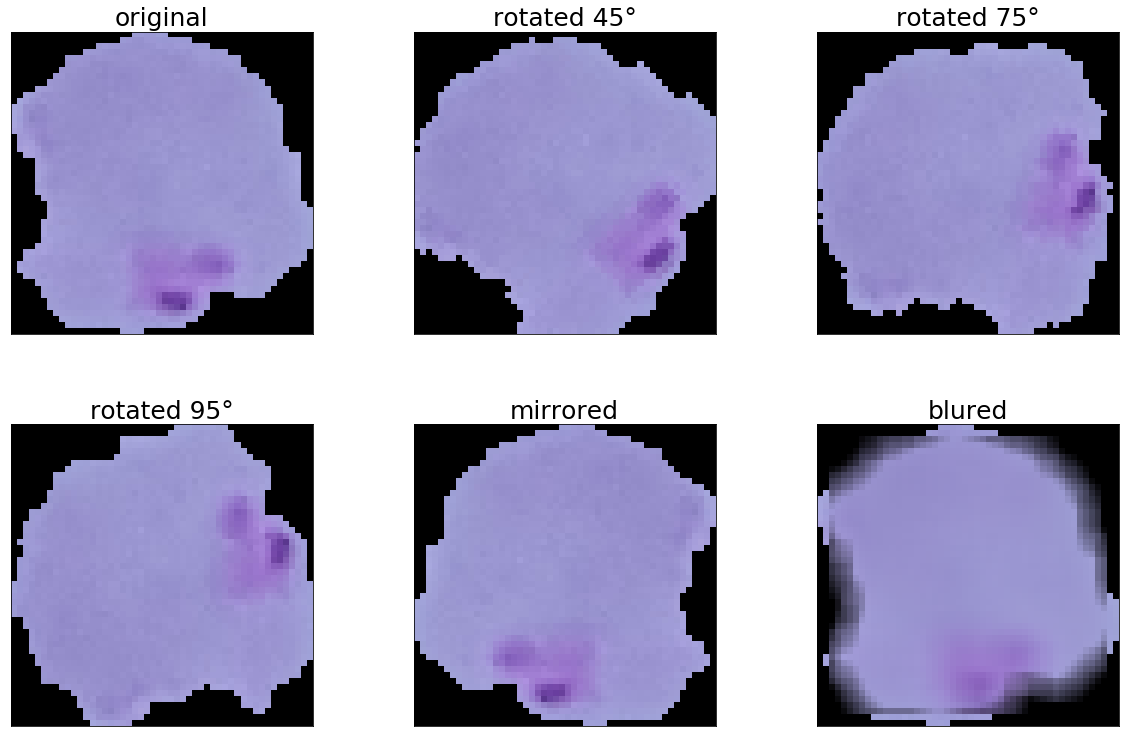

In [10]:
image = preprocess_data("data/cell_images/Parasitized/C99P60ThinF_IMG_20150918_141520_cell_107.png", 50,50)
augmented, auglabel = augment_data(image, 0 ,rotations=[45,75,95], mirror = True, blur = True)
images = []
images.append(np.array(image))
images.extend(augmented)
#print(len(images))
titles = ["original", "rotated 45°", "rotated 75°", "rotated 95°", "mirrored", "blured"]
plt.figure(1, figsize=(20,20))
n = 0
for img in images:
    n += 1
    plt.subplot(3,3,n)
    plt.subplots_adjust(hspace=0.3, wspace= 0.3)
    plt.imshow(img)
    plt.title(titles[n-1], fontsize=25)
    plt.xticks([]), plt.yticks([])

plt.show()

# Generate all Data and Labels

In [11]:
# Generates the dataset and the respective labels in a way it can be used as training and test data later on
def generate_data(path, h_img, w_img, mode='RGB', rotations=None, mirror=False, blur=False):
    '''
    Args:
        image_path: image path, relative to the location of this project
        h_img: new height of image
        w_img: new width of image
        mode='RGB'
        rotations: rotates the image by angles in list, e.g rotations=[45,75,95]
        mirror: mirrors the image vertically if true
        blur: blurs the image if true
    Returns:
        data: List of data/images
        labels: List of labels corresponding to the data
    '''
    data = []
    labels = []
    clazz_data = load_data(path)
    for clazz in clazz_data:
        for img in clazz_data.get(clazz):
            img_path = path + "/" + clazz[0] + "/" + img
            #print(img_path)
            prep_img = preprocess_data(img_path, h_img, w_img)
            #print(np.array(prep_img).shape)
            if prep_img is None:
                continue
            data.append(np.array(prep_img))
            labels.append(clazz[1])
            augm_data, augm_label = augment_data(prep_img,clazz[1], rotations, mirror, blur)
            data.extend(augm_data)
            labels.extend(augm_label)
    return data, labels
        
    

In [14]:
#checking whether data and label generation work properly
data, labels = generate_data("data/cell_images", 50, 50, rotations=[45,75], blur = True)
#dat_44, labs_44 = generate_data("data/cell_images", 44, 44, rotations=[45,75,120], mirror = True, blur = True)
#orig_d, orig_l =generate_data("data/cell_images", 50, 50)
#orig_d_44, orig_l_44 = generate_data("data/cell_images", 44, 44)
#print(len(orig_d_44))
#print(len(orig_l_44))


#There should be 110232 images in total
print('Number of data: {} \nNumber of labels: {}'.format(len(data), len(labels)))

# There should be 55116 images for each class
print('Expecting labels to be 0 : l[55114] = {}, l[55115] = {} \nExpecting labels to be 1 : l[55116] = {}, l[55117] = {}'.format(labels[55114],labels[55115],labels[55116],labels[55117]))

27558
27558
Number of data: 110232 
Number of labels: 110232
Expecting labels to be 0 : l[55114] = 0, l[55115] = 0 
Expecting labels to be 1 : l[55116] = 1, l[55117] = 1


## Save/Load Data

In [15]:
# saves data and labels to .npy files
def save_data(cell_file_name, cells, label_file_name, labels):
    '''
    Args:
        cell_file_name: String -> name the file with the data should have
        label_file_name: String -> name the file with the label should have
    '''
    cellz = np.array(cells)                 
    labelz = np.array(labels)
    #print(cells.shape)
    #print(labelz.shape)
    np.save(cell_file_name, cellz)
    np.save(label_file_name, labelz)


In [17]:
#uncomment if you want to save your results
#save_data("data_augm",data, "labels_augm",labels)
#save_data("data_augm_44",dat_44, "labels_augm_44",labs_44)
save_data("orig_d", orig_d, "orig_l",orig_l)
save_data("orig_d_44", orig_d_44, "orig_l_44", orig_l_44)

In [11]:
# from: https://www.kaggle.com/sharp1/malaria-cells-classification-through-keras
# loads data and label .npy file from current directory
def load_saved_data(data, labels):
    '''
    Args:
        data: name of data file without .npy
        labels: name of label file without .npy
    Returns:
        c: list containing cell-data
        l_ list containing respective labels
    '''
    c=np.load(data + ".npy")
    l=np.load(labels + ".npy")
    return c,l

In [13]:
#o_d, o_l = load_saved_data("orig_d", "orig_l")
#o_d_44, o_l_44 = load_saved_data("orig_d_44", "orig_l_44")
c,l = load_saved_data("data_augm","labels_augm")
#ce,la = load_saved_data("data_augm_44", "labels_augm_44")
#print('number of data o_d: {} \nnumber of labels o_l: {}'.format(len(o_d), len(o_l)))
#print('number of data o_d_44: {} \nnumber of labels o_l_44: {}'.format(len(o_d_44), len(o_l_44)))
print('number of data c: {} \nnumber of labels l: {}'.format(len(c), len(l)))
#print('number of data ce: {} \nnumber of labels la: {}'.format(len(ce), len(la)))

number of data c: 110232 
number of labels l: 110232


## Data-Visualization

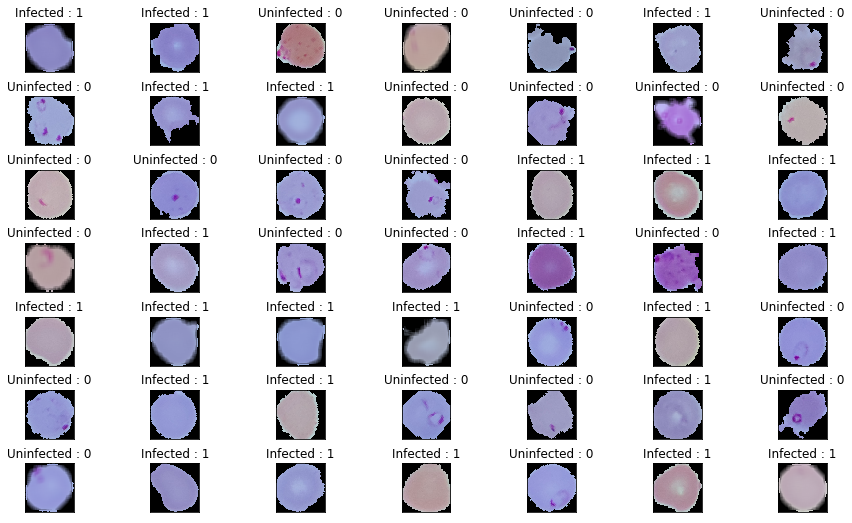

In [21]:
plt.figure(1, figsize=(15,9))
n=0
for i in range(49):
    n +=1
    r = np.random.randint(0, c.shape[0], 1)
    plt.subplot(7,7,n)
    plt.subplots_adjust(hspace=0.5, wspace= 0.5)
    plt.imshow(c[r[0]])
    plt.title('{} : {}'.format('Infected' if l[r[0]] == 1 else 'Uninfected', l[r[0]]))
    # Disable xticks:
    plt.xticks([]), plt.yticks([])
plt.show()

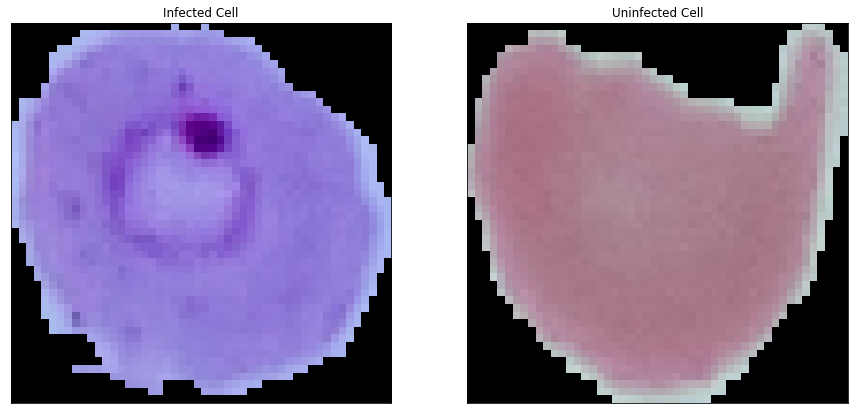

In [22]:
plt.figure(1, figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(c[0])
plt.title('Infected Cell')
plt.xticks([]), plt.yticks([])

plt.figure(1, figsize=(15,7))
plt.subplot(1,2,2)
plt.imshow(c[60000])
plt.title('Uninfected Cell')
plt.xticks([]), plt.yticks([])

plt.show()

## Shuffle and Normalize Data

In [14]:
# randomly shuffles the data and normalizes the image data 
def shuffle_and_normalize(data, labels):
    '''
    Args:
        data: data that is to be used for trainin, testing, evaluating the CNN
        labels: corresponding labels
    Returns:
        randomly shuffled data and labels (the indexes of data and it's corresponing label are shuffled in the same way)
    '''
    r = np.arange(data.shape[0])

    # shuffles all the values in r
    # Return evenly spaced values within a given interval(Here: 0-110231)
    # For integer arguments the function is equivalent to the Python built-in range function, but returns an
    # ndarray rather than a list.
    np.random.shuffle(r)
    # rearanges/shuffles order of cells
    cells = data[r]
    # rearanges/shuffles order of labels
    labelz = labels[r]
    # Copy of the array, cast to a specified type.
    # Pixel values of cells range from 0 to 255
    # To scale them to range from 0 to 1 -> divide by 255
    cells = cells.astype(np.float32)/255
    labelz = labelz.astype(np.int32)
    return cells, labelz
  

In [15]:
#ce_o,la_o = shuffle_and_normalize(o_d, o_l)
#ce_o_44, la_o_44 = shuffle_and_normalize(o_d_44, o_l_44)
c_ells, l_abels = shuffle_and_normalize(c,l)
#ce_lls,la_bels = shuffle_and_normalize(ce,le)

## Split Data

In [17]:
# test_size: represent the proportion of the dataset to include in the test split
# random_state: random_state is the random number generator; If None, the random number generator is the RandomState 
# instance used by np.random. -> optional (default:none)
train_x, test_x, train_y, test_y = train_test_split(c_ells, l_abels,
                                         test_size = 0.1)#,
                                         #random_state = 111)

In [ ]:
print('train data shape : {}\ntest data shape : {}'.format(train_x.shape,test_x.shape))
# Check if no data is lost: should be 110232 in total
#print(train_x.shape[0] + eval_x.shape[0] + test_x.shape[0])
#print(train_y.shape[0] + eval_y.shape[0] + test_y.shape[0])

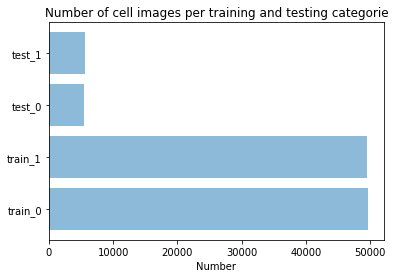

In [18]:
# Plot split labels
# Visualize repartition of data
objects = ('train_0', 'train_1', 'test_0', 'test_1')
y_pos = np.arange(len(objects))
a = []
b = []
for i in train_y:
    if i == 0:
        a.append(i)
    else:
        b.append(i)
        
c = []
e = []
for j in test_y:
    if j == 0:
        c.append(j)
    else:
        e.append(j)
performance = [len(a),len(b),len(c),len(e)]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Number')
plt.title('Number of cell images per training and testing categorie')

plt.show()

## Setup CNN

CustomNet failed. Accuracy varying between 0.49 and 0.50
-> change learning rate, check if convolution actually possible etc...

model = models.Sequential()
model.add(layers.Conv2D(90, (3,3), activation="relu",padding='same', input_shape=(50,50,3)))
model.add(layers.Conv2D(90, (3,3), activation="relu",padding='same'))
model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True))
model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.Conv2D(30, (3,3), activation="relu",padding='same'))
model.add(layers.Conv2D(30, (3,3), activation="relu",padding='same'))
model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.Conv2D(25, (3,3), activation="relu",padding='same'))
model.add(layers.Conv2D(15, (3,3), activation="relu",padding='same'))
model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True))
model.add(layers.Conv2D(15, (3,3), activation="relu",padding='same'))
model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.Conv2D(15, (3,3), activation="relu",padding='same'))
model.add(layers.Conv2D(10, (3,3), activation="relu",padding='same'))
model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True))
model.add(layers.Conv2D(10, (3,3), activation="relu",padding='same'))
model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.Conv2D(5, (3,3), activation="relu",padding='same'))
model.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True))
model.add(layers.Conv2D(5, (3,3), activation="relu",padding='same'))
model.add(layers.Conv2D(5, (3,3), activation="relu",padding='same'))
model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(2000, activation="relu"))
model.add(layers.Dense(1000, activation="relu"))
model.add(layers.Dense(20, activation="softmax"))
'''

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(50, (5,5), activation='relu',padding='same', input_shape=(50,50,3)))
model.add(layers.Conv2D(90, (3,3), activation='relu',padding='valid'))
model.add(layers.Conv2D(10, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), 2))
model.add(layers.Conv2D(5, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2), 2, padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(2000, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(train_x, train_y, epochs=5)

In [ ]:
# Save entire model to a HDF5 file
model.save('03_my_model.h5')


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5,5), activation='relu',padding='same', input_shape=(50,50,3)))
model.add(layers.Conv2D(32, (5,5), activation='relu',padding='valid'))
model.add(layers.MaxPooling2D((5,5), 2, padding='valid'))
model.add(layers.Conv2D(64, (5,5), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3,3), padding='valid'))
model.add(layers.MaxPooling2D((3,3), 2, padding='valid'))

model.add(layers.Flatten())
model.add(layers.Dense(2000, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [ ]:
TODO:
    - Confusion Matrix
    - predict
    - history plotten
    - git READ.md
        - Description of the program and its purpose
        - Installation and usage guidelines (you are responsible for a flawless running of 
                                             the program and reproducibility of your results)


## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Malaria Project - Implementation<br/>
Detecting Malaria cells using CNN and TF 2.0 <br/>
by Lukas Wagner, Laila Westphal <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2019 Lukas Wagner, Laila Westphal

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Acknowledgements

